# Проект Телеком 

Соловьев Н.С.

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. 

Задача — создать модель для прогноза оттока клиентов телекомуникационной компании.

Метрики: roc_auc >= 0.85, accuracy.

План работы:
- [загрузка_данных](#загрузка_данных)
- [подготовка_данных](#подготовка_данных)
    - [предобработка](#предобработка)
    - [исследование_данных](#исследование_данных)
    - [подготовка_данных_к_ML](#подготовка_данных_к_ML)
- [ML](#ML)
 - [обучение_моделей](#обучение_моделей)
 - [тестирование_лучшей_модели](#тестирование_лучшей_модели)
 - [анализ](#анализ)
- [Вывод](#Вывод)

### Загрузка данных.

In [1]:
!pip install catboost -q
!pip install SQLAlchemy -q
!pip install phik -q
!pip install lightgbm -q
!pip install optuna -q
!pip install joblib -q
!pip install torch -q
!pip install skorch -q
!pip install shap -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import joblib
import math
import numpy as np
import phik
import warnings
import optuna
import lightgbm
import catboost
import torch
import torch.nn as nn
import skorch
import torch.optim as optim
import torch.nn.functional as F
import shap


from sqlalchemy import create_engine 
from sklearn.model_selection import train_test_split, cross_val_score,cross_val_predict, StratifiedKFold
from sklearn.preprocessing import  OneHotEncoder,  MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer,roc_curve, roc_auc_score, accuracy_score, confusion_matrix, precision_score, recall_score,precision_recall_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from optuna.samplers import TPESampler
from catboost import CatBoostClassifier, Pool, cv
from skorch.callbacks import EarlyStopping
from skorch import NeuralNetClassifier

In [3]:
RS = 131123

подключение к бд

In [4]:
db_config = {
    'user': 'praktikum_student', 
    'pwd': 'Sdf4$2;d-d30pp', 
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, 
    'db': 'data-science-final' 
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [5]:
engine = create_engine(connection_string)

In [6]:
query = '''
    SELECT table_name
    FROM information_schema.tables
    WHERE table_schema = 'telecom';
'''

In [7]:
try:
    tables = pd.read_sql(query, engine)
    print('Список таблиц в базе данных:')
    print(tables)
except Exception as e:
    print(f'Ошибка при получении списка таблиц: {e}')

Список таблиц в базе данных:
  table_name
0   contract
1   internet
2   personal
3      phone


In [8]:
def get_table_data(table_name):
    query = f'SELECT * FROM {table_name};'
    try:
        df = pd.read_sql(query, engine)
        return df
    except Exception as e:
        print(f'Ошибка при чтении данных из {table_name}: {e}')
        return None

In [9]:
tables = ['telecom.contract', 'telecom.personal', 'telecom.internet', 'telecom.phone']

In [10]:
table_data = {}

In [11]:
for table_name in tables:
    df = get_table_data(table_name)
    
    if df is not None:
        print(f"\nТаблица: {table_name}")
        print()
        print(df.info())
        print()
        print("\nПревью:")
        print(df.head())

        table_data[table_name] = df


Таблица: telecom.contract

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB
None


Превью:
   customerID   BeginDate     EndDate            Type PaperlessBilling  \
0  4472-LVYGI  2020-02-01        None        Two year              Yes   
1  3115-CZMZD  2020-02-01        None        Two year               No   
2  3668-QPYBK  2018-08-09  2019-12-01  Month-to-month              Yes   
3  5709-LVOEQ  2020-02-01      

Подключились успешно. В нашем распоряжении следующие таблицы с данными:

-contract — информация о договорах;

-personal — персональные данные клиентов;

-internet — информация об интернет-услугах;

-phone — информация об услугах телефонии.

Колличество и название таблиц соответсвует условию. Ключ customerID

<a name='подготовка_данных'></a>

### Подготовка данных

Устраним ошибки в именах колонок там где это необходимо. 

In [12]:
contract_df = get_table_data('telecom.contract')
personal_df = get_table_data('telecom.personal')
internet_df = get_table_data('telecom.internet')
phone_df = get_table_data('telecom.phone')

In [13]:
internet_df.columns = internet_df.iloc[0]
internet_df = internet_df.iloc[1:]

In [14]:
phone_df.columns = phone_df.iloc[0]
phone_df = phone_df.iloc[1:]

In [15]:
print(internet_df.info())
print()
print(phone_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 1 to 5517
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 1 to 6361
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


In [16]:
duplicates_customer_id = contract_df[contract_df.duplicated('customerID', keep=False)]

if not duplicates_customer_id.empty:
    print('Обнаружены дубликаты в столбце customerID таблицы contract_df:')
    print(duplicates_customer_id)
else:
    print('Дубликатов в столбце customerID таблицы contract_df не обнаружено.')

Дубликатов в столбце customerID таблицы contract_df не обнаружено.


На основе contract_df сформируем общую таблицу и проведем полноценный EDA. Основная таблица contract ( содержит столбец с датой окончания контракта, впоследствии трансформируем в целевую переменную) не содержит дубликатов в ключе customer_id ( что важно при объединении ) и имеет 7043 уникальных объекта, далее таблица personal - 7043 строк, internet - 5518 строк и phone 6362. Почти все признаки за исключением месячных/общих расходов - категориальные. Признаки SeniorCitizen ,а так же даны начала и окончания контрака - имеют неверный типы int/object - соотвествнно. Исправим далее. Будем мержить все таблицы к основной таблице contract по ключу customer_id.

In [17]:
df = contract_df.merge(personal_df, on='customerID', how='left')
df = df.merge(internet_df, on='customerID', how='left')
df = df.merge(phone_df, on='customerID', how='left')

In [18]:
print(df.info())
print()
print(df.sample(3))
print()
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


#### Предобработка

In [19]:
df.drop(['customerID'], axis=1, inplace=True)

теперь не нужен

In [20]:
df.sample(10)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
5689,2019-03-07,None,One year,No,Mailed check,64.85,950.75,Male,0,No,Yes,DSL,Yes,No,Yes,No,No,Yes,No
22,2018-09-12,2020-01-01,Month-to-month,Yes,Electronic check,80.65,144.15,Female,0,No,No,Fiber optic,No,No,No,No,Yes,No,No
184,2018-12-02,2019-11-01,Month-to-month,Yes,Electronic check,50.15,168.15,Male,0,Yes,Yes,DSL,No,No,Yes,No,No,No,No
3651,2018-12-11,None,One year,Yes,Credit card (automatic),79.05,5552.50,Male,0,No,No,Fiber optic,No,Yes,No,No,No,No,Yes
1092,2018-10-30,2019-10-01,Month-to-month,No,Electronic check,73.60,520.00,Male,0,No,No,Fiber optic,No,No,No,No,No,No,Yes
485,2018-11-10,2019-10-01,Month-to-month,Yes,Electronic check,44.85,2572.95,Male,1,Yes,No,DSL,No,No,No,No,Yes,Yes,NaN
5943,2019-08-13,None,Two year,No,Bank transfer (automatic),54.65,2553.70,Male,0,Yes,Yes,DSL,Yes,No,No,Yes,No,No,No
3311,2019-10-26,None,One year,Yes,Bank transfer (automatic),19.85,996.95,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1846,2019-03-30,2019-12-01,Month-to-month,Yes,Electronic check,105.90,334.65,Male,1,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
4321,2019-03-10,None,Month-to-month,No,Electronic check,94.75,3653.00,Male,1,No,No,Fiber optic,No,No,No,No,Yes,Yes,Yes


In [21]:
missing_df = df[df['TotalCharges'].isna()]
print(missing_df.head(11))

       BeginDate EndDate      Type PaperlessBilling  \
0     2020-02-01    None  Two year              Yes   
1     2020-02-01    None  Two year               No   
3     2020-02-01    None  Two year               No   
6     2020-02-01    None  Two year               No   
7     2020-02-01    None  Two year               No   
9     2020-02-01    None  Two year               No   
10    2020-02-01    None  One year              Yes   
11    2020-02-01    None  Two year              Yes   
4408  2020-02-01    None  Two year               No   
5160  2020-02-01    None  Two year               No   
6839  2020-02-01    None  Two year               No   

                  PaymentMethod  MonthlyCharges  TotalCharges  gender  \
0     Bank transfer (automatic)           52.55           NaN  Female   
1                  Mailed check           20.25           NaN    Male   
3                  Mailed check           80.85           NaN  Female   
6                  Mailed check           25.75

думаю что пользователи которые заключили договор в последний день имеющихся у нас данных - статистически не значимы. 

In [22]:
missing_data = df[df['InternetService'].isna()]
print(missing_data.sample(30))

       BeginDate     EndDate            Type PaperlessBilling  \
4220  2019-07-16        None        Two year              Yes   
6347  2019-03-23        None        Two year              Yes   
3438  2019-02-16        None        Two year               No   
1019  2019-03-20        None        One year               No   
550   2019-04-27  2019-10-01  Month-to-month              Yes   
2359  2018-10-22        None        Two year               No   
2912  2019-03-04        None  Month-to-month               No   
4882  2019-03-17        None        Two year               No   
5852  2019-05-09        None  Month-to-month               No   
159   2019-03-31  2019-11-01  Month-to-month               No   
4837  2018-11-12        None  Month-to-month               No   
6813  2019-03-24        None        Two year               No   
3881  2019-03-26        None        One year               No   
2124  2019-08-12        None        Two year              Yes   
6823  2018-09-07        N

In [23]:
missing_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1526 entries, 1 to 7038
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         1526 non-null   object 
 1   EndDate           113 non-null    object 
 2   Type              1526 non-null   object 
 3   PaperlessBilling  1526 non-null   object 
 4   PaymentMethod     1526 non-null   object 
 5   MonthlyCharges    1526 non-null   float64
 6   TotalCharges      1520 non-null   float64
 7   gender            1526 non-null   object 
 8   SeniorCitizen     1526 non-null   int64  
 9   Partner           1526 non-null   object 
 10  Dependents        1526 non-null   object 
 11  InternetService   0 non-null      object 
 12  OnlineSecurity    0 non-null      object 
 13  OnlineBackup      0 non-null      object 
 14  DeviceProtection  0 non-null      object 
 15  TechSupport       0 non-null      object 
 16  StreamingTV       0 non-null      object 
 17  

In [24]:
for column in ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    print(df[column].value_counts())
    print()

InternetService
Fiber optic    3096
DSL            2421
Name: count, dtype: int64

OnlineSecurity
No     3498
Yes    2019
Name: count, dtype: int64

OnlineBackup
No     3088
Yes    2429
Name: count, dtype: int64

DeviceProtection
No     3095
Yes    2422
Name: count, dtype: int64

TechSupport
No     3473
Yes    2044
Name: count, dtype: int64

StreamingTV
No     2810
Yes    2707
Name: count, dtype: int64

StreamingMovies
No     2785
Yes    2732
Name: count, dtype: int64



Я не вижу закономерностей, и распределение всех этих признаков примерно равное yes/no. Тк все услуги относятся к интернету, в признаке InternetService указывается только тип подключения и группа пользователей с пропуками одна и таже - предположу что у этой группы нет интернета. Соответсвенно все пропуки можно заполнить No. Соответсвенно у пользователей с пропусками в MultipleLines - нет телефонной линии. 

In [25]:
df[['OnlineSecurity','InternetService', 'MultipleLines', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
    'StreamingMovies']] = df[[ 'OnlineSecurity', 'InternetService', 'MultipleLines',  'OnlineBackup', 'DeviceProtection',
                              'TechSupport', 'StreamingTV', 'StreamingMovies']].fillna('No')

Создадим целевую переменную на сонове Enddate

In [26]:
df['churn'] = ~df['EndDate'].isnull()
df['churn'].fillna(0, inplace=True)
df['churn'] = df['churn'].astype(int)

In [27]:
df['churn'].describe()

count    7043.000000
mean        0.265370
std         0.441561
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: churn, dtype: float64

Теперь будем проверять все операции с дф что бы не сильно качнуть целевой. 

Пропуски EndDate по логике заполним последей датой данных

In [28]:
df['EndDate'].fillna('2020-02-01 00:00:00', inplace=True)

In [29]:
df['EndDate'].sample(3)

1391             2019-11-01
6983    2020-02-01 00:00:00
474              2019-11-01
Name: EndDate, dtype: object

In [30]:
df = df.dropna().reset_index(drop = True)

In [31]:
df['churn'].describe()

count    7032.000000
mean        0.265785
std         0.441782
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: churn, dtype: float64

In [32]:
df.isna().sum()

BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
churn               0
dtype: int64

C пропусками разобрались. Займемся типом. 

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7032 non-null   object 
 1   EndDate           7032 non-null   object 
 2   Type              7032 non-null   object 
 3   PaperlessBilling  7032 non-null   object 
 4   PaymentMethod     7032 non-null   object 
 5   MonthlyCharges    7032 non-null   float64
 6   TotalCharges      7032 non-null   float64
 7   gender            7032 non-null   object 
 8   SeniorCitizen     7032 non-null   int64  
 9   Partner           7032 non-null   object 
 10  Dependents        7032 non-null   object 
 11  InternetService   7032 non-null   object 
 12  OnlineSecurity    7032 non-null   object 
 13  OnlineBackup      7032 non-null   object 
 14  DeviceProtection  7032 non-null   object 
 15  TechSupport       7032 non-null   object 
 16  StreamingTV       7032 non-null   object 


In [34]:
df.sample(3)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,churn
2003,2019-08-13,2020-02-01 00:00:00,Month-to-month,Yes,Electronic check,56.0,764.55,Female,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No,0
322,2019-02-14,2019-12-01,Month-to-month,No,Electronic check,78.3,2564.30,Male,0,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,No,1
4514,2019-05-15,2020-02-01 00:00:00,Month-to-month,Yes,Electronic check,81.2,3292.30,Male,0,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Yes,0


In [35]:
df['TotalCharges'] = df['TotalCharges'].round().astype(int)
df['MonthlyCharges'] = df['MonthlyCharges'].round().astype(int)

In [36]:
numeric_columns = df.select_dtypes(include='number').columns

df[numeric_columns] = df[numeric_columns].astype('int32')

In [37]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'], format='%Y/%m/%d')
df['EndDate'] = pd.to_datetime(df['EndDate'], errors='coerce', format='%Y-%m-%d %H:%M:%S')

Определим типы

In [38]:
df[['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']] = df[['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']].astype(str)

Посмотрим выбросы. 

In [39]:
columns_of_interest = ['TotalCharges', 'MonthlyCharges']

In [40]:
for column in columns_of_interest:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    has_outliers = ((df[column] < lower) | (df[column] > upper)).any()
    
    if has_outliers:
        print(f'{column}: выбросы есть')
    else:
        print(f'{column}: выбросов нет')

TotalCharges: выбросов нет
MonthlyCharges: выбросов нет


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7032 non-null   datetime64[ns]
 1   EndDate           7032 non-null   datetime64[ns]
 2   Type              7032 non-null   object        
 3   PaperlessBilling  7032 non-null   object        
 4   PaymentMethod     7032 non-null   object        
 5   MonthlyCharges    7032 non-null   int32         
 6   TotalCharges      7032 non-null   int32         
 7   gender            7032 non-null   object        
 8   SeniorCitizen     7032 non-null   object        
 9   Partner           7032 non-null   object        
 10  Dependents        7032 non-null   object        
 11  InternetService   7032 non-null   object        
 12  OnlineSecurity    7032 non-null   object        
 13  OnlineBackup      7032 non-null   object        
 14  DeviceProtection  7032 n

#### Генерация признаков 

Создадим признак длительность контракта

In [42]:
#df['ContractDuration'] = ((df['EndDate'] - df['BeginDate']).dt.days ) 

In [43]:
#df['ContractDuration'] = df['ContractDuration'].astype('int32')

Создадим признак счеткик доп. услуг. 

In [44]:
#services_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

In [45]:
#df['TotalServices'] = (df[services_columns].sum(axis=1)).round().astype('int32')

In [46]:
#df['TotalServices'].value_counts()

поделим на расходы по группам. 

In [47]:
#df['TotalCharges'].describe()

In [48]:
#low = df['TotalCharges'].min()
#medium = df['TotalCharges'].quantile(0.25)
#high = df['TotalCharges'].quantile(0.75)

In [49]:
#df['ChargesCategory'] = pd.cut(df['TotalCharges'],bins=[low, medium, high, df['TotalCharges'].max()],labels=['Low', 'Medium', 'High'])

In [50]:
#df['ChargesCategory'].value_counts()

In [51]:
#df.isna().sum()

In [52]:
#df = df.dropna().reset_index(drop = True)

Удивтельно, но после генерации признаков модели давали результат - хуже! Возможно из за  высокой мультиколлинеарности с производными столбцами

<a name='исследование_данных'></a>

#### Исследование данных

In [53]:
monthly_churn = df.groupby([df['BeginDate'].dt.year, df['BeginDate'].dt.month])['churn'].sum()

In [54]:
monthly_churn.index = monthly_churn.index.map(lambda x: f'{x[0]}-{x[1]}')

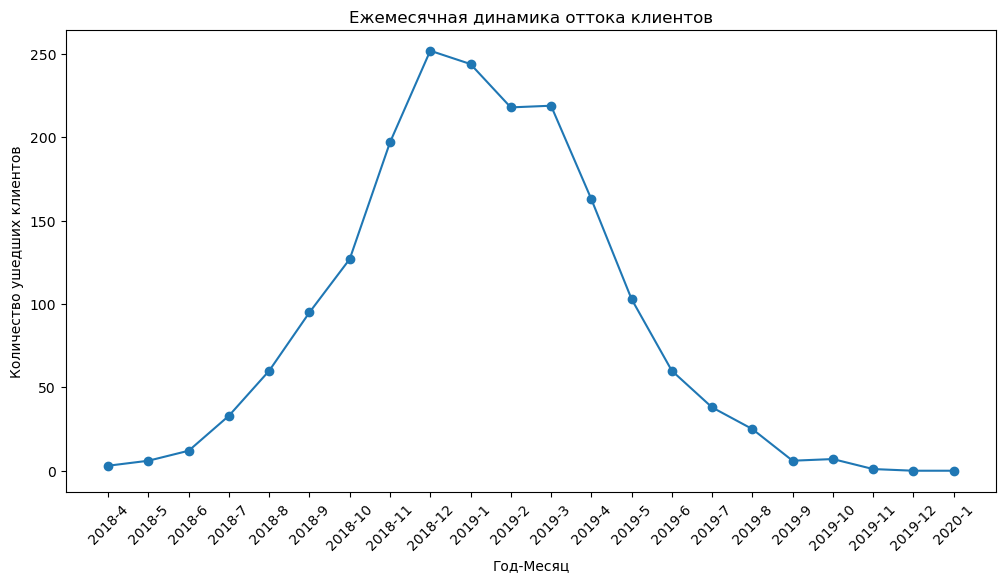

In [55]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_churn.index, monthly_churn.values, marker='o')
plt.title('Ежемесячная динамика оттока клиентов')
plt.xlabel('Год-Месяц')
plt.ylabel('Количество ушедших клиентов')
plt.xticks(rotation=45)
plt.show()

По графику видно что колличество уходящих клиентов начало довольно стремительно увеличивваться каждый месяц начиная с 06.2018 и до 2019, далее до 09.2019 колличество уходящих клиентов уменьшалось. Пик почти на 250 клиентов которые ушли приходится на декабрь 2018. 

( нормальное распределние по уходу клиентов, волноваться не о чем ))) 

необходимо убрать столбцы с датами во избежании утечки. 

In [56]:
df.drop(['BeginDate', 'EndDate'], axis=1, inplace=True)

Проверим ошибки и неявные дубликаты.

In [57]:
categorical_columns = df[['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']]

In [58]:
for column in categorical_columns:
    unique_values = df[column].unique()
    print(f"Уникальные значения в столбце {column}:\n{unique_values}\n")

Уникальные значения в столбце Type:
['Month-to-month' 'Two year' 'One year']

Уникальные значения в столбце PaperlessBilling:
['Yes' 'No']

Уникальные значения в столбце PaymentMethod:
['Mailed check' 'Electronic check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

Уникальные значения в столбце gender:
['Male' 'Female']

Уникальные значения в столбце SeniorCitizen:
['0' '1']

Уникальные значения в столбце Partner:
['No' 'Yes']

Уникальные значения в столбце Dependents:
['No' 'Yes']

Уникальные значения в столбце InternetService:
['DSL' 'Fiber optic' 'No']

Уникальные значения в столбце OnlineSecurity:
['Yes' 'No']

Уникальные значения в столбце OnlineBackup:
['Yes' 'No']

Уникальные значения в столбце DeviceProtection:
['No' 'Yes']

Уникальные значения в столбце TechSupport:
['No' 'Yes']

Уникальные значения в столбце StreamingTV:
['No' 'Yes']

Уникальные значения в столбце StreamingMovies:
['No' 'Yes']

Уникальные значения в столбце MultipleLines:
['No' 'Yes']



все значения соответствуют логике

Теперь посмотрим на корреляцию.

In [59]:
df.phik_matrix(verbose=False)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,churn
Type,1.000000,0.106151,0.277528,0.389910,0.507599,0.000000,0.085800,0.179294,0.146126,0.503776,0.152239,0.099016,0.137817,0.180169,0.067123,0.070375,0.065750,0.251283
PaperlessBilling,0.106151,1.000000,0.368945,0.467776,0.204881,0.000000,0.241715,0.010489,0.170650,0.231145,0.000000,0.196937,0.161234,0.055354,0.344114,0.325351,0.253299,0.295194
PaymentMethod,0.277528,0.368945,1.000000,0.398729,0.349919,0.000000,0.291989,0.244661,0.222859,0.323013,0.261704,0.282245,0.306678,0.270893,0.377241,0.378375,0.339987,0.448559
MonthlyCharges,0.389910,0.467776,0.398729,1.000000,0.761683,0.000000,0.304769,0.205065,0.182993,0.918572,0.549937,0.628608,0.667848,0.576903,0.835998,0.833334,0.676887,0.357725
TotalCharges,0.507599,0.204881,0.349919,0.761683,1.000000,0.000000,0.147474,0.424677,0.118000,0.507898,0.545664,0.655863,0.672043,0.567130,0.660277,0.665891,0.606461,0.281001
gender,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.016788,0.007277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SeniorCitizen,0.085800,0.241715,0.291989,0.304769,0.147474,0.000000,1.000000,0.018075,0.323629,0.160452,0.056897,0.102206,0.090818,0.092485,0.163223,0.185621,0.221386,0.232897
Partner,0.179294,0.010489,0.244661,0.205065,0.424677,0.000000,0.018075,1.000000,0.651635,0.000000,0.222040,0.219762,0.237725,0.186312,0.192973,0.183090,0.220874,0.232215
Dependents,0.146126,0.170650,0.222859,0.182993,0.118000,0.000000,0.323629,0.651635,1.000000,0.107328,0.124648,0.031464,0.010181,0.096565,0.017176,0.056742,0.032697,0.252268
InternetService,0.503776,0.231145,0.323013,0.918572,0.507898,0.000000,0.160452,0.000000,0.107328,1.000000,0.240905,0.233205,0.232532,0.239149,0.272629,0.272562,0.225602,0.195860


Признак гендер почти не имеет связи с другими признаками. Таргет имеет не очень выраженные взаимосвязи почти со всеми признаками. Есть связь у месячных и общих платежей, но тут все соотвествует логике. Удалять пока ничего не будем посмотрим на распределения признаков. 

Теперь посмотрим основные статистические показатели 

In [60]:
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None
print (df.describe(include='all').T)

                    count unique               top  freq     mean      std  \
Type                 7032      3    Month-to-month  3875      NaN      NaN   
PaperlessBilling     7032      2               Yes  4168      NaN      NaN   
PaymentMethod        7032      4  Electronic check  2365      NaN      NaN   
MonthlyCharges   7,032.00    NaN               NaN   NaN    64.80    30.09   
TotalCharges     7,032.00    NaN               NaN   NaN 2,283.29 2,266.77   
gender               7032      2              Male  3549      NaN      NaN   
SeniorCitizen        7032      2                 0  5890      NaN      NaN   
Partner              7032      2                No  3639      NaN      NaN   
Dependents           7032      2                No  4933      NaN      NaN   
InternetService      7032      3       Fiber optic  3096      NaN      NaN   
OnlineSecurity       7032      2                No  5017      NaN      NaN   
OnlineBackup         7032      2                No  4607      Na

Самые распространенные тип оплаты - раз в месяц, электронным чеком, а интернет подключение - через оптоволокно. В среднем клиенты почти по ровну разделены на группы в браке/не в браке, почти у трети есть дети  и  16% пенсионеры. Так же в среднем у клиентов подключено 2 и более двух доп услуг, 2.283 уе средние затраты общие, 64.80 - месячные.

Теперь поближе посмотрим на признаки. 

In [61]:
columns_to_plot = ['MonthlyCharges','TotalCharges']

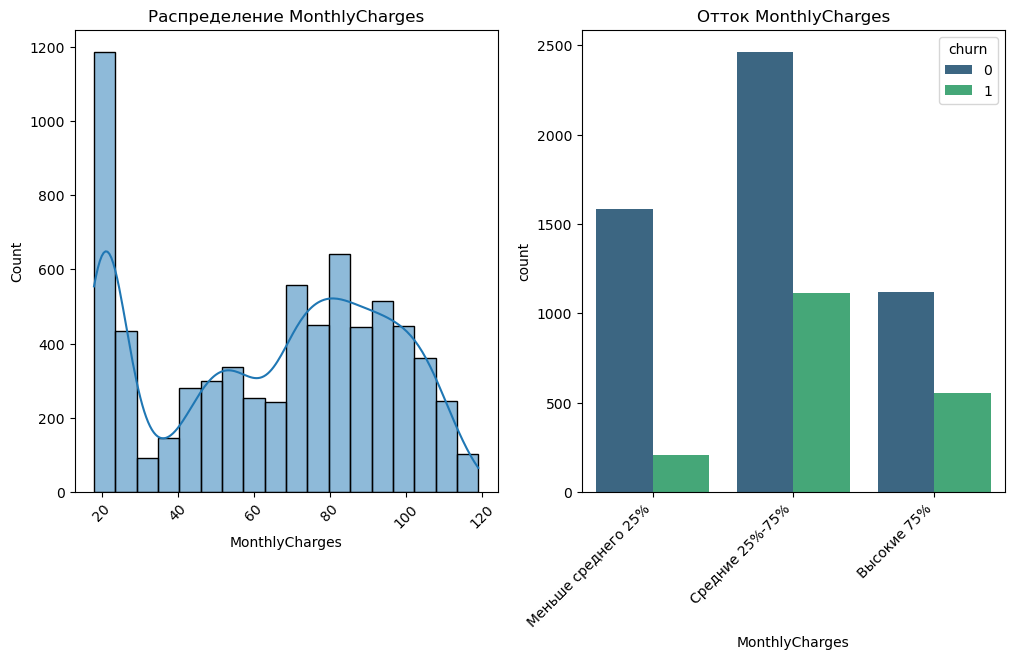

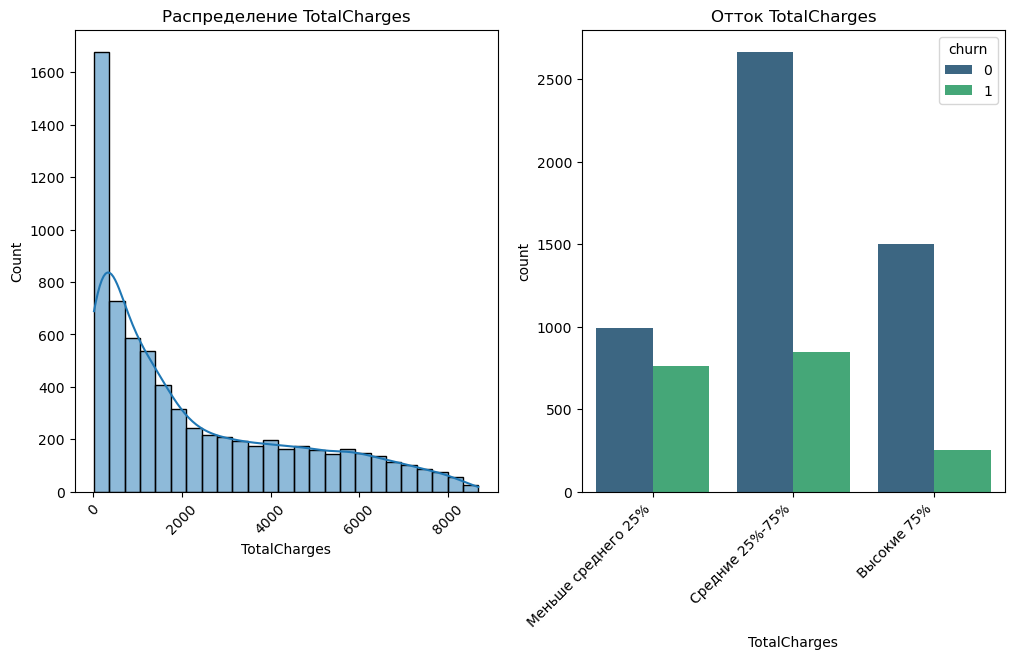

In [62]:
for column in columns_to_plot:
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(df[column], kde=True)
    plt.title(f'Распределение {column}')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    quantile_bins = pd.qcut(df[column], q=[0, 0.25, 0.75, 1], labels=['Меньше среднего 25%', 'Средние 25%-75%', 'Высокие 75%'])
    sns.countplot(x=quantile_bins, hue='churn', data=df, palette='viridis')
    plt.title(f'Отток {column}')
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [63]:
columns_to_plot = ['Type', 'PaperlessBilling', 'PaymentMethod',  'gender',  'Dependents',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines', 'DeviceProtection', 'Partner', 'SeniorCitizen']

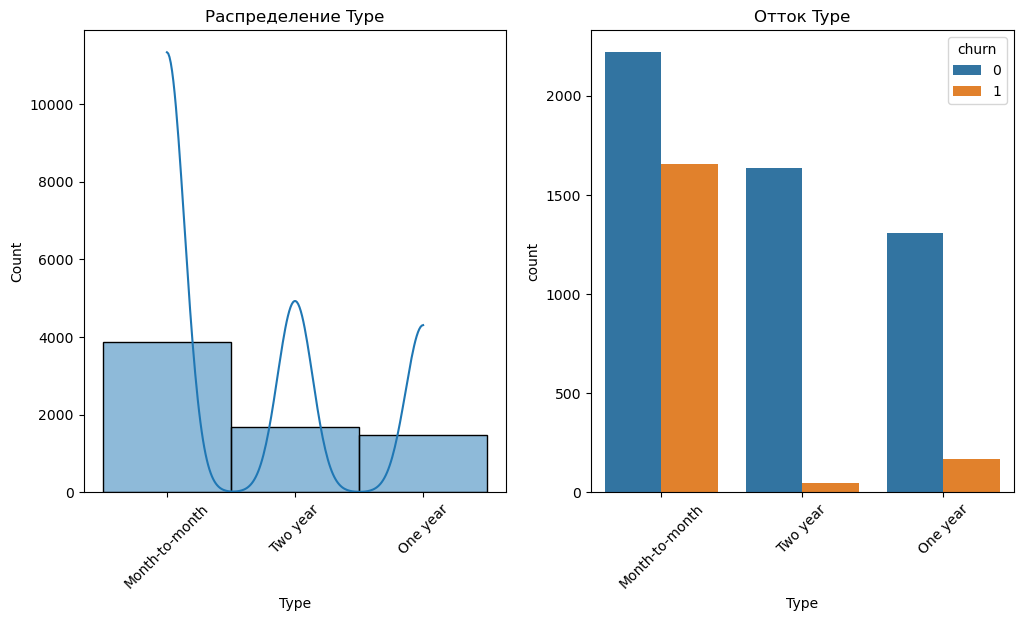

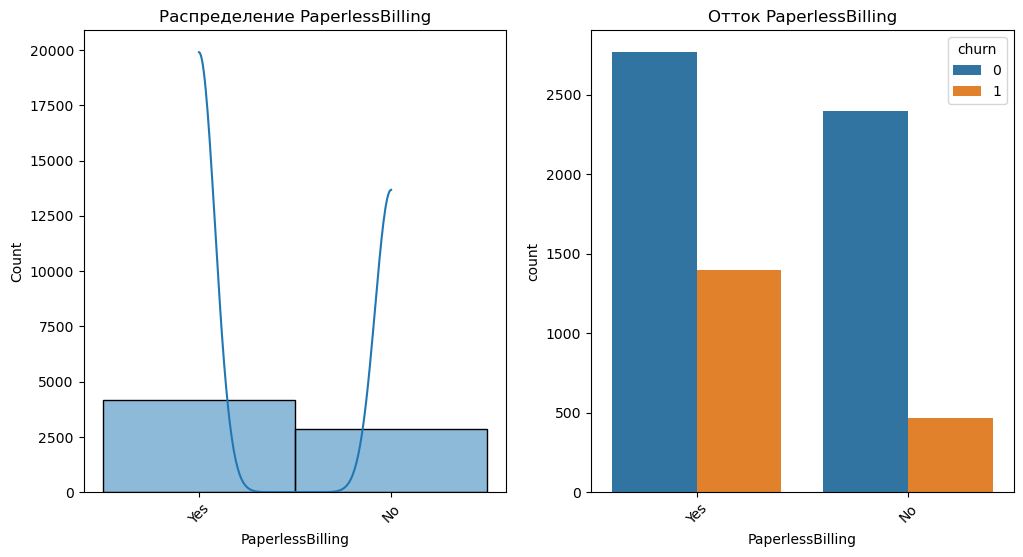

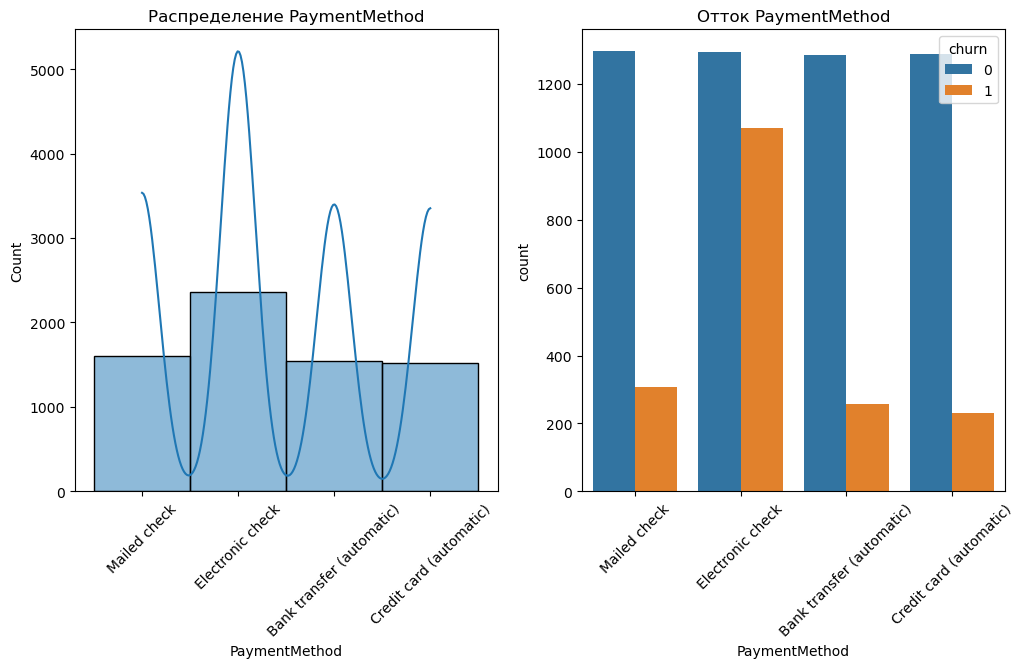

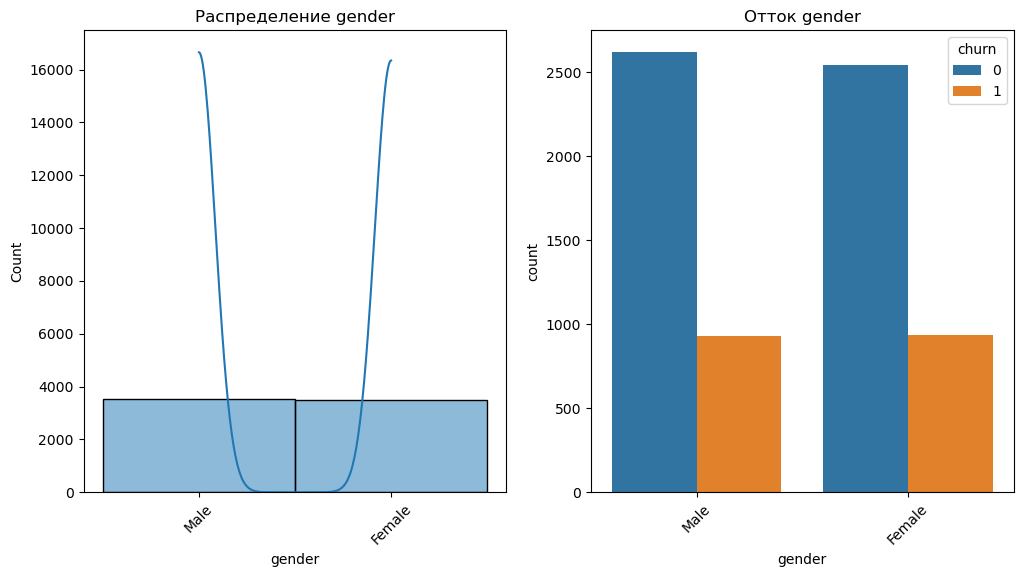

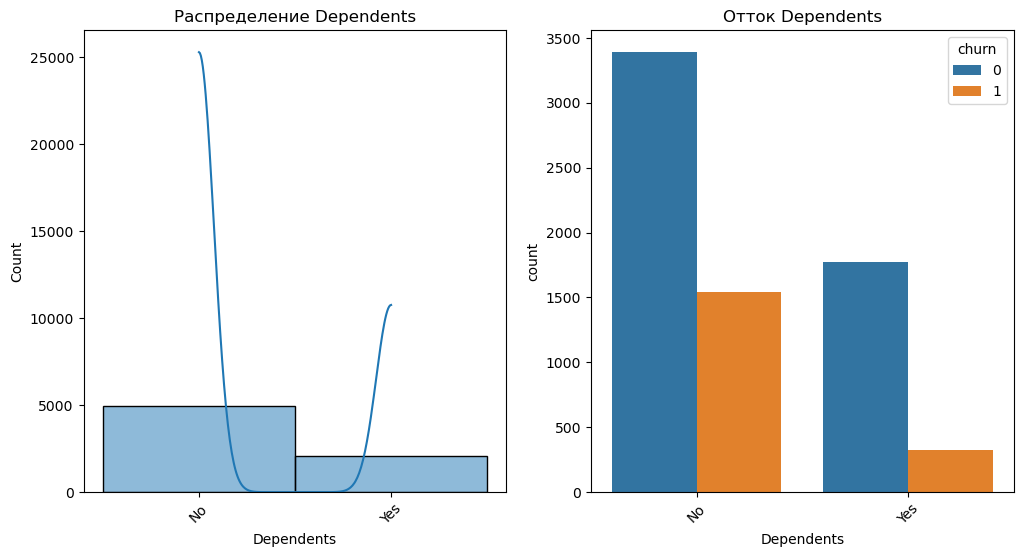

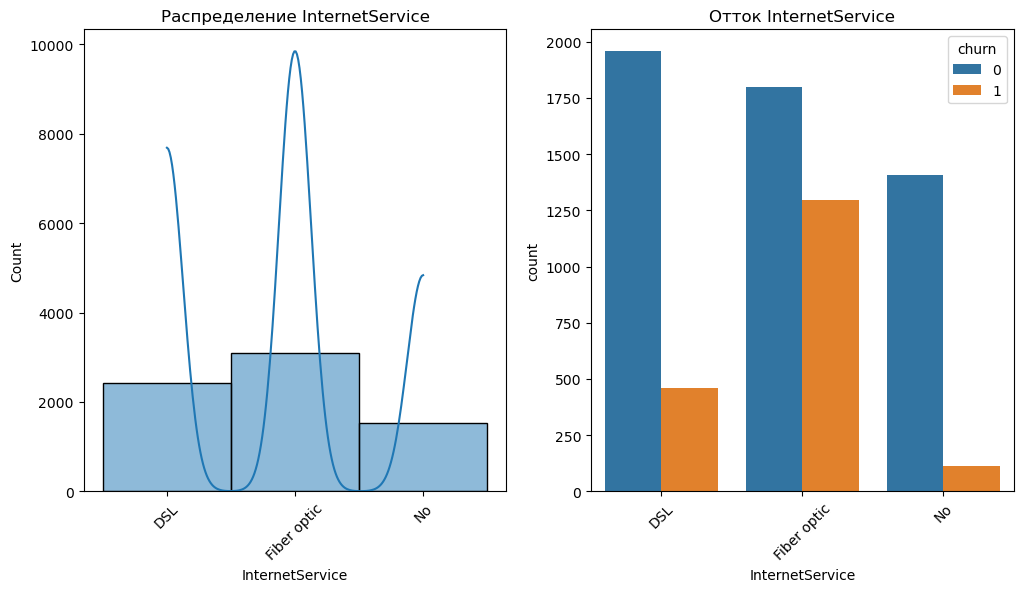

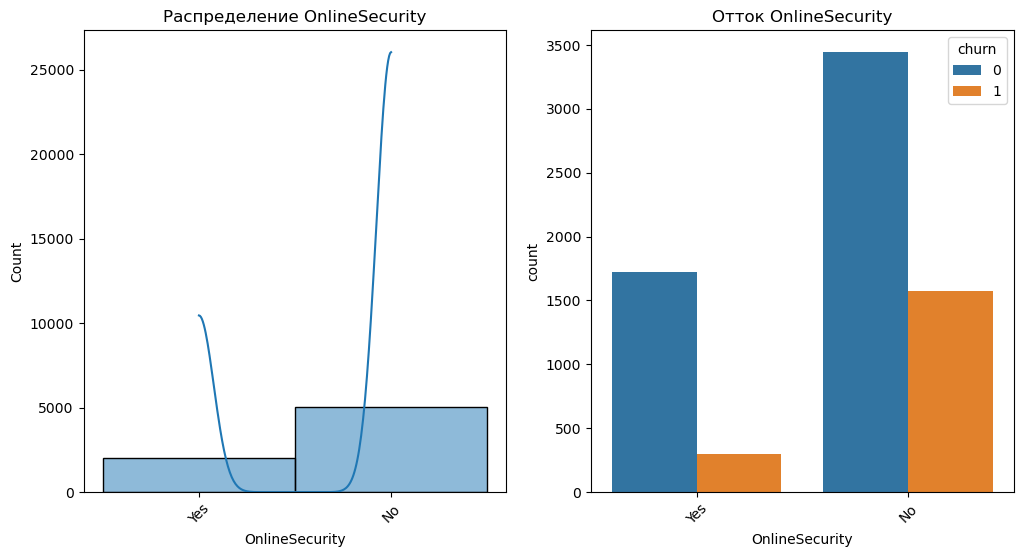

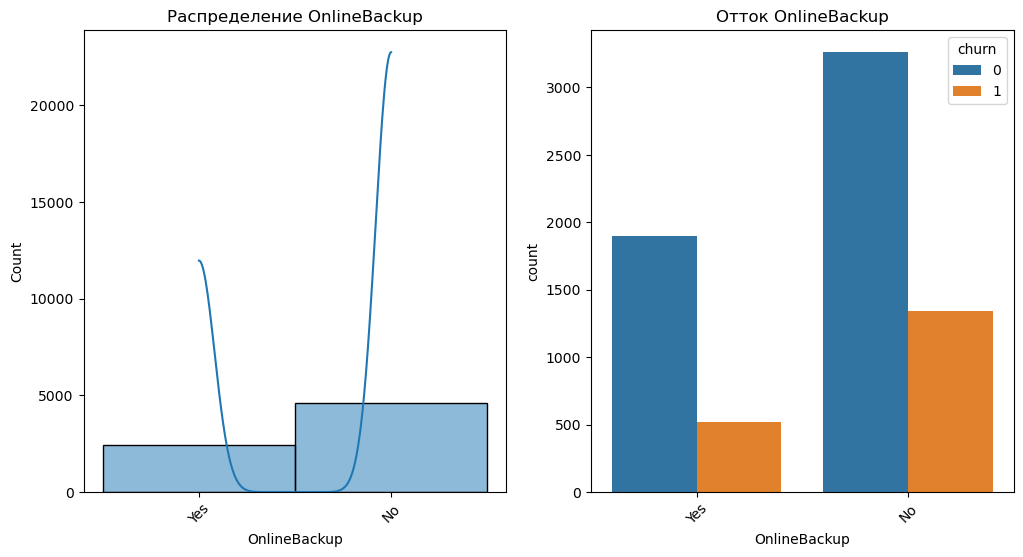

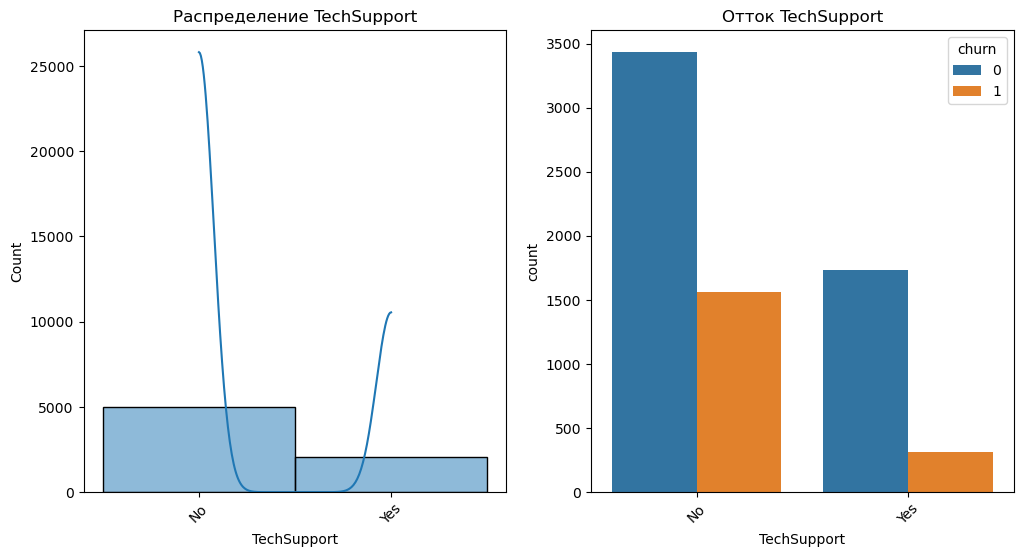

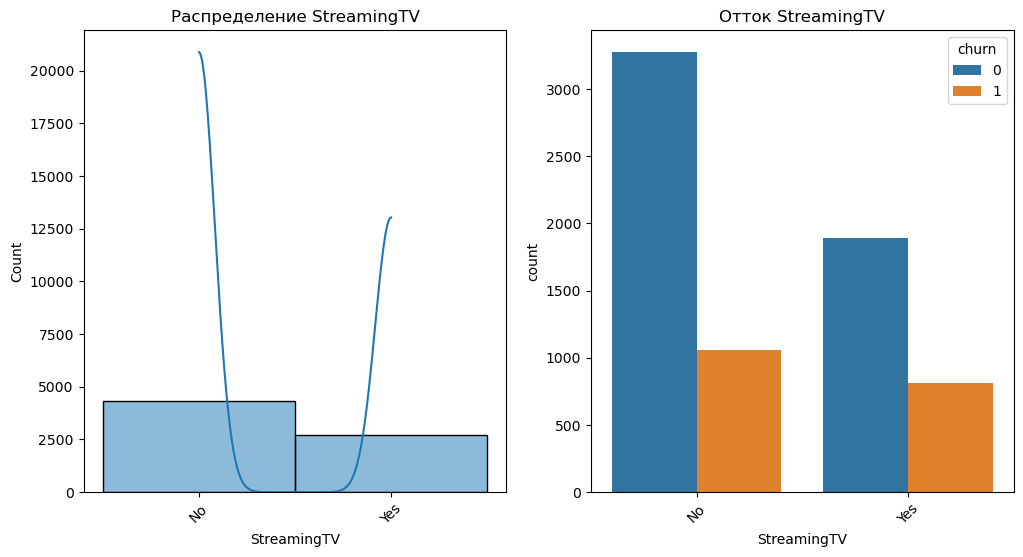

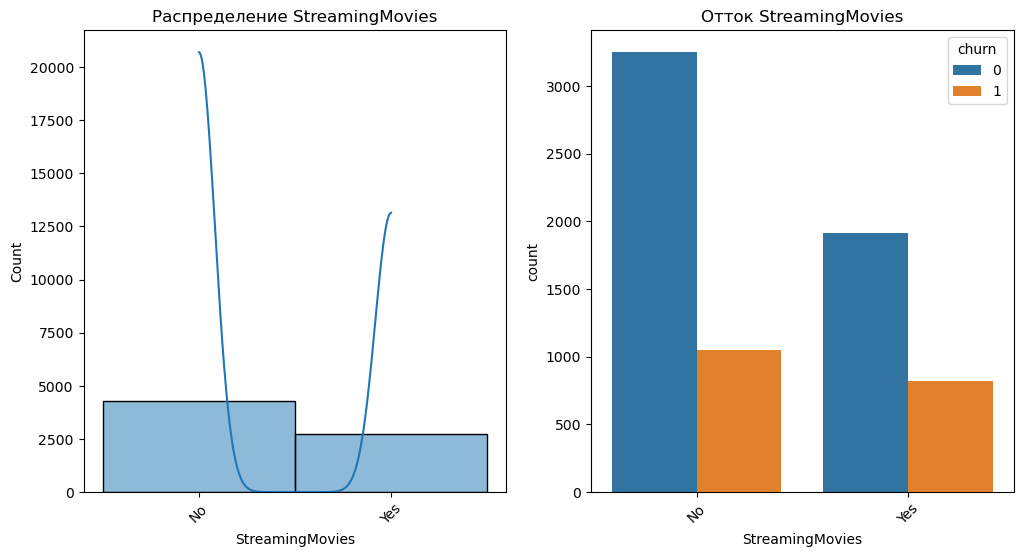

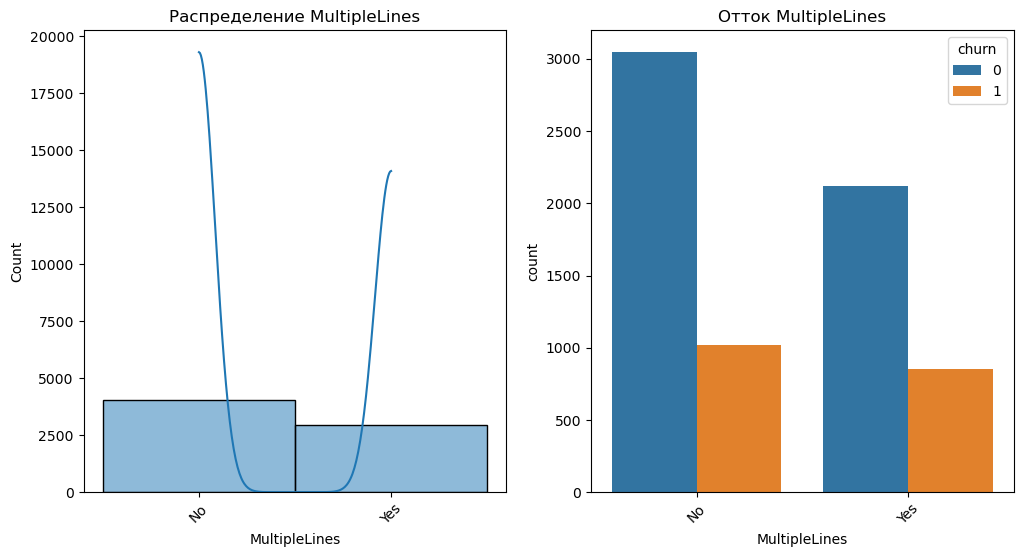

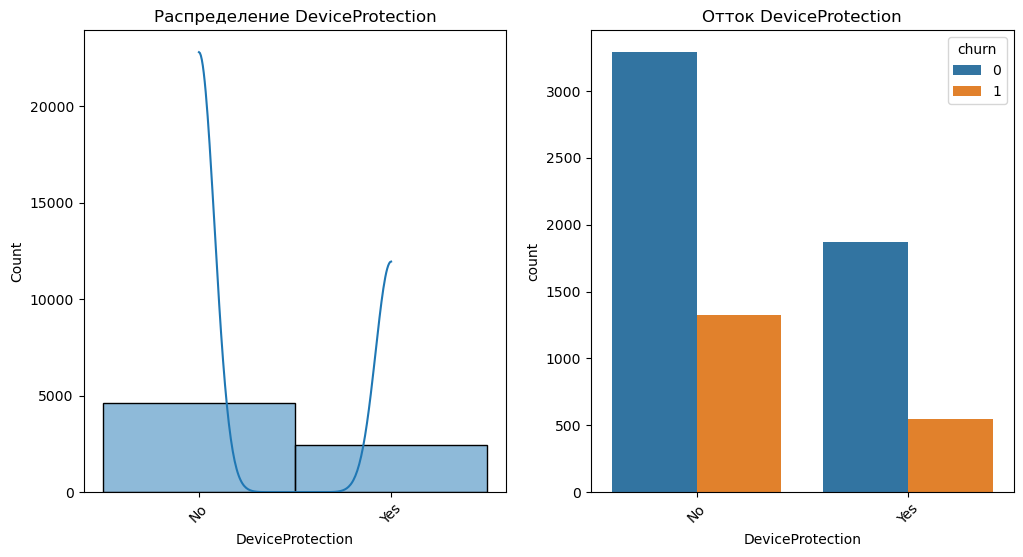

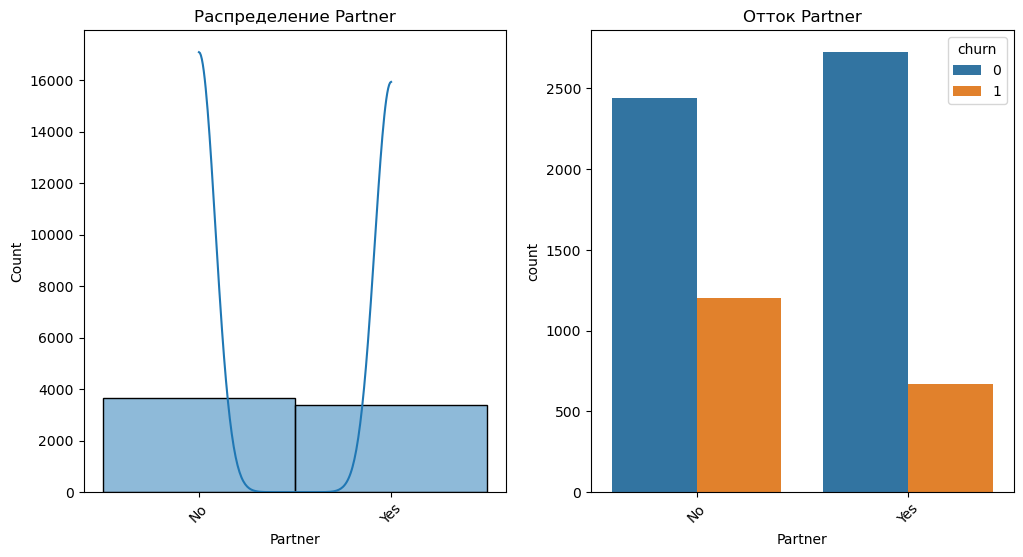

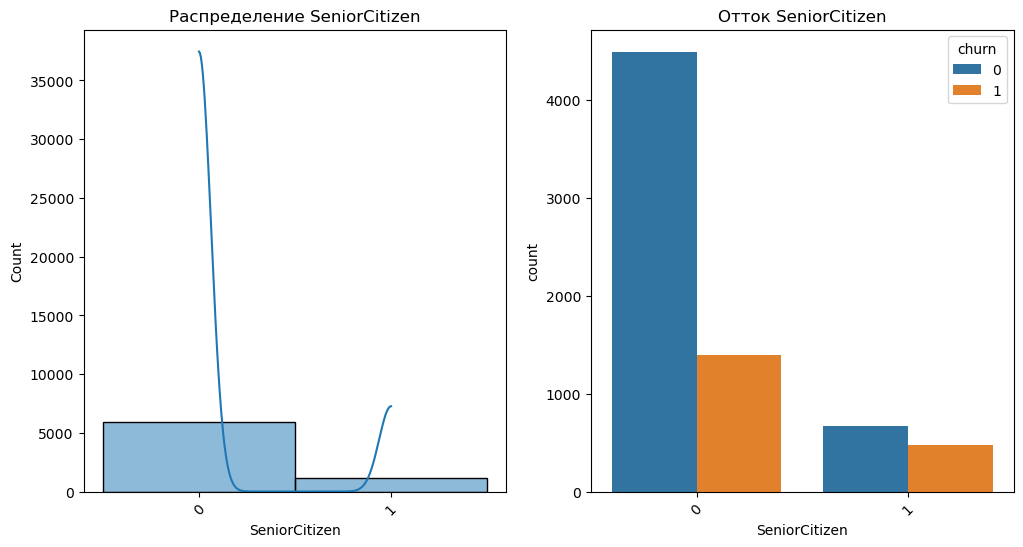

In [64]:
for column in columns_to_plot:
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(df[column], kde=True)
    plt.title(f'Распределение {column}')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    sns.countplot(x=column, hue='churn', data=df)
    plt.title(f'Отток {column}')
    plt.xticks(rotation=45)

    plt.show()


Исходя из корреляции и распределения признаков удалим лишние.

In [65]:
df.drop(['gender', 'Partner', 'MultipleLines'], axis=1, inplace=True)

Распределение целевой переменной.

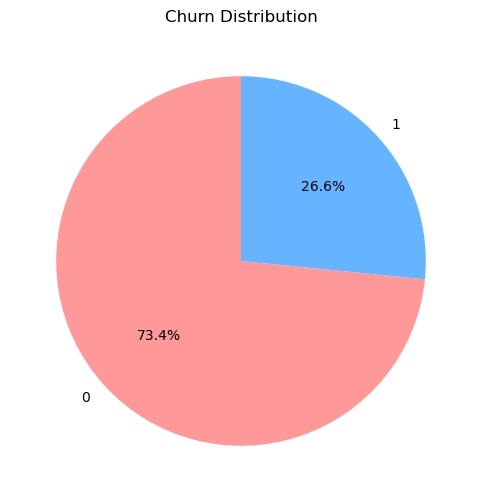

In [66]:
churn_counts = df['churn'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff'])
plt.title('Churn Distribution')
plt.show()

Очень занятные графики. Больший отток в группах которые плаят раз в месяц  ( что наверное логично тк и цена обычно выше и промежуток в данных такой что те кто платят раз в год или два и планируют прекратить контракт по истечению платежа еще не ушли), имеют эллектронный расчетный лист, платят электронным чеком, не пенсионеры, без детей, без партнера, имеют оптоволоконную сеть, а так же не имеют доп услуг и входят в среднюю группу по расходам. Дисбаланс целевой переменной 1/3. 

<a name='подготовка_данных_к_ML'></a>

#### Подготовка данных к ML

In [67]:
X = df.drop('churn', axis=1)
y = df['churn']

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Type              7032 non-null   object
 1   PaperlessBilling  7032 non-null   object
 2   PaymentMethod     7032 non-null   object
 3   MonthlyCharges    7032 non-null   int32 
 4   TotalCharges      7032 non-null   int32 
 5   SeniorCitizen     7032 non-null   object
 6   Dependents        7032 non-null   object
 7   InternetService   7032 non-null   object
 8   OnlineSecurity    7032 non-null   object
 9   OnlineBackup      7032 non-null   object
 10  DeviceProtection  7032 non-null   object
 11  TechSupport       7032 non-null   object
 12  StreamingTV       7032 non-null   object
 13  StreamingMovies   7032 non-null   object
 14  churn             7032 non-null   int32 
dtypes: int32(3), object(12)
memory usage: 741.8+ KB


In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=RS)

In [70]:
print('Размеры тренировочного набора:', X_train.shape, y_train.shape)
print('Размеры тестового набора:', X_test.shape, y_test.shape)

Размеры тренировочного набора: (5274, 14) (5274,)
Размеры тестового набора: (1758, 14) (1758,)


In [71]:
categorical_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'Dependents',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'DeviceProtection', 'SeniorCitizen'] 
numeric_features = ['MonthlyCharges', 'TotalCharges']

In [72]:
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])


categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore', drop='first'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ],
    remainder='passthrough'
)

После многократного тестирования различных иснтрументов - лучшие результаты показывает ohe и mms. так же отмечу из за большого колличества категориальных признаков необходимо избегать дамми-ловушки.

In [73]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

Dummy

In [74]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train_transformed, y_train)
y_pred_dummy = dummy_clf.predict(X_test_transformed)
roc_auc_dummy = roc_auc_score(y_test, y_pred_dummy)

print(f' Дамми модель дает резульат ROC AUC: {roc_auc_dummy}')

 Дамми модель дает резульат ROC AUC: 0.5


In [75]:
rfc = RandomForestClassifier(random_state=RS)
lgb = LGBMClassifier( random_state=RS)
cb = CatBoostClassifier(verbose=False, random_seed=RS)

In [76]:
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', rfc)
])

In [77]:
pipeline_lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', lgb)
])

In [78]:
pipeline_catboost = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', cb)
])

### ML

Для подбора параметров будем использовать Optuna.

<a name='ML'></a>

#### Обучение моделей RandomForestClassifier, CatBoostClassifier, LGBMClassifier. 

<a name='обучение_моделей'></a>

In [79]:
best_model = None
best_params = None
best_roc_auc = 0.0

In [80]:
sampler = optuna.samplers.TPESampler(seed=RS)

In [81]:
def objective_rf(trial):
    params = {
       'classifier__class_weight': 'balanced', 
       'classifier__n_estimators': trial.suggest_int('classifier__n_estimators', 1000, 2000),
       'classifier__max_depth': trial.suggest_int('classifier__max_depth', 2, 4),
       'classifier__min_samples_split': trial.suggest_float('classifier__min_samples_split', 0.1, 1, log=True),
       'classifier__min_samples_leaf': trial.suggest_int('classifier__min_samples_leaf', 1, 20),
    }
    pipeline_rf.set_params(**params)
    cv_results = cross_val_score(pipeline_rf, X_train, y_train, cv=StratifiedKFold(n_splits=3), scoring='roc_auc')
    roc_auc = cv_results.mean()

    global best_roc_auc, best_params, best_model
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_params = params.copy()
        best_model = pipeline_rf

    return roc_auc

In [82]:
study_rf = optuna.create_study(direction='maximize', sampler=sampler)
study_rf.optimize(objective_rf, n_trials=100, n_jobs=-1)

[I 2023-12-17 06:43:53,194] A new study created in memory with name: no-name-917c8ce6-9a9a-47d0-af38-0a157f8b027d
[I 2023-12-17 06:45:28,155] Trial 0 finished with value: 0.8242009961966744 and parameters: {'classifier__n_estimators': 1121, 'classifier__max_depth': 2, 'classifier__min_samples_split': 0.2152424229690105, 'classifier__min_samples_leaf': 8}. Best is trial 0 with value: 0.8242009961966744.
[I 2023-12-17 06:45:33,703] Trial 1 finished with value: 0.831408255632616 and parameters: {'classifier__n_estimators': 1013, 'classifier__max_depth': 2, 'classifier__min_samples_split': 0.3404061136299457, 'classifier__min_samples_leaf': 5}. Best is trial 1 with value: 0.831408255632616.
[I 2023-12-17 06:45:33,726] Trial 7 finished with value: 0.831408255632616 and parameters: {'classifier__n_estimators': 1570, 'classifier__max_depth': 3, 'classifier__min_samples_split': 0.24779891603029067, 'classifier__min_samples_leaf': 14}. Best is trial 1 with value: 0.831408255632616.
[I 2023-12-1

In [83]:
def objective_lgbm(trial):
    params = {
        'classifier__boosting_type': 'gbdt',
        'classifier__objective': 'binary',
        'classifier__class_weight': 'balanced',
        'classifier__metric': 'auc',
        'classifier__learning_rate': trial.suggest_float('classifier__learning_rate', 0.001, 0.1, log=True),
        'classifier__n_estimators': trial.suggest_int('classifier__n_estimators', 1000, 2000),
        'classifier__max_depth': trial.suggest_int('classifier__max_depth', 2, 6),
        'classifier__num_leaves': trial.suggest_int('classifier__num_leaves', 2, 50),
        'classifier__min_split_gain': trial.suggest_float('classifier__min_split_gain', 0.0, 1.0),
        'classifier__min_child_weight': trial.suggest_float('classifier__min_child_weight', 0.001, 1.0),
        'classifier__min_child_samples': trial.suggest_int('classifier__min_child_samples', 5, 50),
        'classifier__subsample': trial.suggest_float('classifier__subsample', 0.5, 1.0),
        'classifier__colsample_bytree': trial.suggest_float('classifier__colsample_bytree', 0.5, 1.0),
    }
    pipeline_lgbm.set_params(**params)
    cv_results = cross_val_score(pipeline_lgbm, X_train, y_train, cv=StratifiedKFold(n_splits=3), scoring='roc_auc')
    roc_auc = cv_results.mean()

    global best_roc_auc, best_params, best_model
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_params = params.copy()
        best_model = pipeline_lgbm

    return roc_auc


In [84]:
study_lgbm = optuna.create_study(direction='maximize', sampler=sampler)
study_lgbm.optimize(objective_lgbm, n_trials=300, n_jobs=-1)

[I 2023-12-17 07:01:37,228] A new study created in memory with name: no-name-4e634203-afe0-42af-8c6e-e36e37bc262f
[I 2023-12-17 07:01:48,412] Trial 0 finished with value: 0.8447830849101362 and parameters: {'classifier__learning_rate': 0.002768904500422749, 'classifier__n_estimators': 1952, 'classifier__max_depth': 5, 'classifier__num_leaves': 42, 'classifier__min_split_gain': 0.1204795723152372, 'classifier__min_child_weight': 0.6192930844499421, 'classifier__min_child_samples': 11, 'classifier__subsample': 0.5336506203473215, 'classifier__colsample_bytree': 0.5527987828639189}. Best is trial 0 with value: 0.8447830849101362.
[I 2023-12-17 07:01:49,826] Trial 5 finished with value: 0.845140038464764 and parameters: {'classifier__learning_rate': 0.030381715391718866, 'classifier__n_estimators': 1403, 'classifier__max_depth': 5, 'classifier__num_leaves': 22, 'classifier__min_split_gain': 0.12479840285565702, 'classifier__min_child_weight': 0.10368704082495493, 'classifier__min_child_sam

In [85]:
def objective_catboost(trial):
    params = {
    'classifier__iterations': trial.suggest_int('classifier__iterations', 1000, 2000),
    'classifier__learning_rate': trial.suggest_float('classifier__learning_rate', 0.001, 0.1, log=True),
    'classifier__depth': trial.suggest_int('classifier__depth', 2, 6),
    'classifier__loss_function': 'Logloss',
    'classifier__eval_metric': 'AUC',
    'classifier__auto_class_weights': 'Balanced',
    'classifier__bootstrap_type': trial.suggest_categorical('classifier__bootstrap_type', ['Bayesian', 'Bernoulli']),
    'classifier__max_bin': trial.suggest_int('classifier__max_bin', 4, 255),
    'classifier__colsample_bylevel': trial.suggest_float('classifier__colsample_bylevel', 0.1, 1.0),  
    'classifier__min_child_samples': trial.suggest_int('classifier__min_child_samples', 5, 50), 
    'classifier__early_stopping_rounds': trial.suggest_int('classifier__early_stopping_rounds', 10, 100),  
    }

    pipeline_catboost.set_params(**params)
    cv_results = cross_val_score(pipeline_catboost, X_train, y_train, cv=StratifiedKFold(n_splits=3), scoring='roc_auc')
    roc_auc = cv_results.mean()

    global best_roc_auc, best_params, best_model
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_params = params.copy()
        best_model = pipeline_catboost

    return roc_auc

In [86]:
study_catboost = optuna.create_study(direction='maximize', sampler=sampler)
study_catboost.optimize(objective_catboost, n_trials=300, n_jobs=-1)

[I 2023-12-17 07:08:33,391] A new study created in memory with name: no-name-704aacf6-7ac8-4092-aeb2-1b5034c5dfef
[I 2023-12-17 07:09:09,700] Trial 0 finished with value: 0.8351604230133315 and parameters: {'classifier__iterations': 1844, 'classifier__learning_rate': 0.05177595643520761, 'classifier__depth': 2, 'classifier__bootstrap_type': 'Bayesian', 'classifier__max_bin': 198, 'classifier__colsample_bylevel': 0.686766401125456, 'classifier__min_child_samples': 46, 'classifier__early_stopping_rounds': 83}. Best is trial 0 with value: 0.8351604230133315.
[I 2023-12-17 07:09:19,827] Trial 5 finished with value: 0.8271975704768355 and parameters: {'classifier__iterations': 1225, 'classifier__learning_rate': 0.0034805135466100426, 'classifier__depth': 6, 'classifier__bootstrap_type': 'Bernoulli', 'classifier__max_bin': 92, 'classifier__colsample_bylevel': 0.72944014850107, 'classifier__min_child_samples': 21, 'classifier__early_stopping_rounds': 78}. Best is trial 0 with value: 0.8351604

In [87]:
print('Лучший результат:', best_roc_auc)
print('Параметры лучшей модели:', best_params)

if best_model is not None:
    joblib.dump(best_model, 'best_model.joblib')

Лучший результат: 0.8494000890869012
Параметры лучшей модели: {'classifier__iterations': 1534, 'classifier__learning_rate': 0.004367270095119018, 'classifier__depth': 4, 'classifier__loss_function': 'Logloss', 'classifier__eval_metric': 'AUC', 'classifier__auto_class_weights': 'Balanced', 'classifier__bootstrap_type': 'Bernoulli', 'classifier__max_bin': 43, 'classifier__colsample_bylevel': 0.6968927604678913, 'classifier__min_child_samples': 11, 'classifier__early_stopping_rounds': 67}


Довольно долго осуществлялся подбор. ЛУчшая модель - CatBoost, чуть хуже справился LGBM, лес - отстает.

#### Обучение нейросети

В качестве нейросети попробуем skorch Classifier. В прошлом проекте подобная нейронка показала очень хороший результат. 

In [88]:
X_train_tensor = torch.FloatTensor(X_train_transformed)
y_train_float = torch.FloatTensor(np.array(y_train))
y_train_float = y_train_float.view(-1, 1)

In [89]:
print (X_train_tensor.shape)  
print (y_train_float.shape) 

torch.Size([5274, 18])
torch.Size([5274, 1])


In [90]:
class SimpleNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(SimpleNNClassifier, self).__init__()
        self.batch_norm_1 = nn.BatchNorm1d(input_size)        
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.LeakyReLU()
        self.batch_norm_2 = nn.BatchNorm1d(hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.LeakyReLU()
        self.batch_norm_3 = nn.BatchNorm1d(hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.LeakyReLU()
        self.batch_norm_4 = nn.BatchNorm1d(hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, output_size)

    def forward(self, x):
        x = self.batch_norm_1(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.batch_norm_2(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.batch_norm_3(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.batch_norm_4(x)
        x = self.fc4(x)
        x = torch.sigmoid(x)
        return x

In [91]:
def objective_net(trial):
    input_size = X_train_tensor.shape[1]
    hidden_size1 = trial.suggest_int('hidden_size1', 1, 32)
    hidden_size2 = trial.suggest_int('hidden_size2', 1, 32)
    hidden_size3 = trial.suggest_int('hidden_size3', 1, 32)  
    lr = trial.suggest_float('lr', 0.0001, 0.1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])

    net = NeuralNetClassifier(
        module=SimpleNNClassifier,
        module__input_size=input_size,
        module__hidden_size1=hidden_size1,
        module__hidden_size2=hidden_size2,
        module__hidden_size3=hidden_size3,  
        module__output_size=1,
        criterion=nn.BCEWithLogitsLoss(),
        optimizer=optim.Adam,
        optimizer__weight_decay=0.01,
        optimizer__lr=lr,
        batch_size=batch_size,
        callbacks=[EarlyStopping(patience=10)],
        device='cuda' if torch.cuda.is_available() else 'cpu',
        max_epochs=100,
        iterator_train__shuffle=True,
        verbose=0
    )

    roc_auc_scores = cross_val_score(net, X_train_tensor, y_train_float, cv=StratifiedKFold(n_splits=3), scoring='roc_auc')
    return roc_auc_scores.mean()

In [92]:
study_net = optuna.create_study(direction='maximize', sampler=sampler)
study_net.optimize(objective_net, n_trials=100, n_jobs=-1)

[I 2023-12-17 07:24:04,058] A new study created in memory with name: no-name-b8c9451e-9182-44b7-b24a-3923b63cd13f
[I 2023-12-17 07:28:29,690] Trial 6 finished with value: 0.8085463429742211 and parameters: {'hidden_size1': 21, 'hidden_size2': 31, 'hidden_size3': 32, 'lr': 0.009959235599590426, 'batch_size': 32}. Best is trial 6 with value: 0.8085463429742211.
[I 2023-12-17 07:30:23,748] Trial 0 finished with value: 0.6922017083072786 and parameters: {'hidden_size1': 23, 'hidden_size2': 1, 'hidden_size3': 5, 'lr': 0.013534699748422004, 'batch_size': 16}. Best is trial 6 with value: 0.8085463429742211.
[I 2023-12-17 07:31:07,045] Trial 1 finished with value: 0.5 and parameters: {'hidden_size1': 12, 'hidden_size2': 10, 'hidden_size3': 32, 'lr': 0.08746592253435878, 'batch_size': 16}. Best is trial 6 with value: 0.8085463429742211.
[I 2023-12-17 07:33:20,319] Trial 4 finished with value: 0.5982196516707387 and parameters: {'hidden_size1': 31, 'hidden_size2': 26, 'hidden_size3': 28, 'lr': 0

По итогам лучшей моделью становится CatBoostClassifier. Нейросеть спраляется на уровне леса.

<a name='тестирование_лучшей_модели'></a>

#### Тестировние 

In [93]:
best_model.fit(X_train, y_train)

y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]
y_pred_test = best_model.predict(X_test)

roc_auc_test = roc_auc_score(y_test, y_pred_proba_test)
accuracy_test = accuracy_score(y_test, y_pred_test)

print('ROC AUC лучшей модели на тестовых данных:', roc_auc_test)
print('Точность лучшей модели:', accuracy_test)

ROC AUC лучшей модели на тестовых данных: 0.8505880772337563
Точность лучшей модели: 0.7514220705346986


Необходимый результат метрики достигнут. 

<a name='анализ'></a>

#### Анализ

Матрица ошибок, полнота и точность.

In [94]:
cm = confusion_matrix(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)

In [95]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_test)
auc_score = auc(recall, precision)

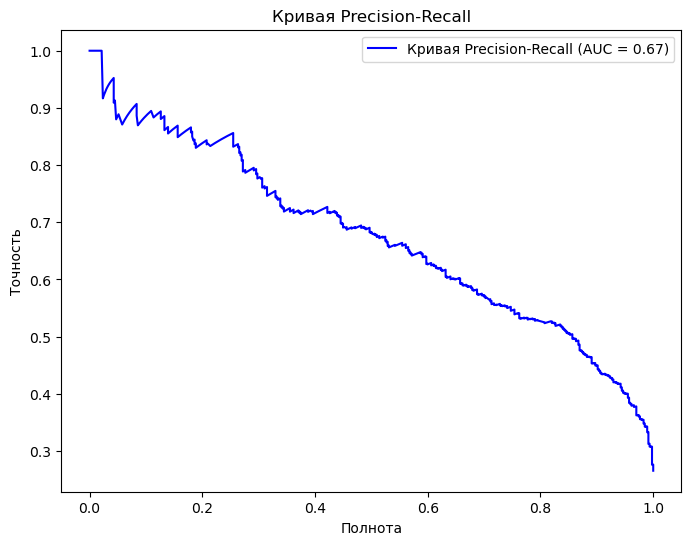

In [96]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label='Кривая Precision-Recall (AUC = {:.2f})'.format(auc_score))
plt.xlabel('Полнота')
plt.ylabel('Точность')
plt.title('Кривая Precision-Recall')
plt.legend()
plt.show()

PR-кривая показывает, что модель демонстрирует относительно хорошие результаты, не выпуклая.Модель может иметь трудности в принятии решений в определенных областях пространства признаков, что приводит к неустойчивости между Precision и Recall и отражается ломаной линией. Значение AUC составляет 0.67, что указывает на лучшую производительность по сравнению с случайным классификатором.

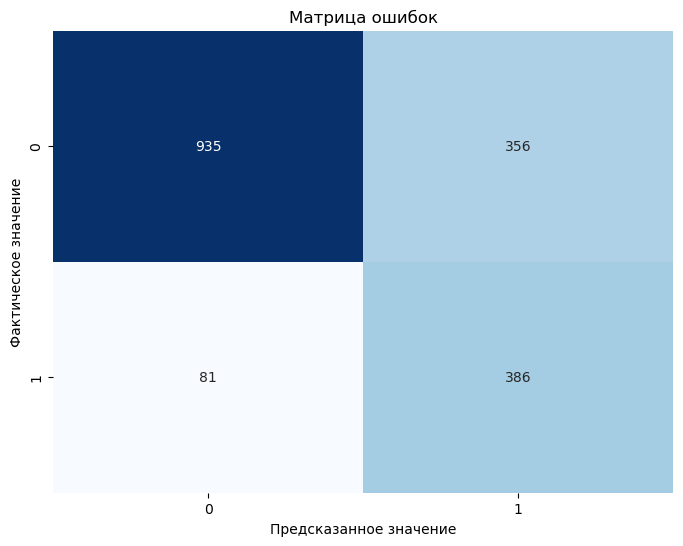

In [97]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Предсказанное значение')
plt.ylabel('Фактическое значение')
plt.title('Матрица ошибок')
plt.show()

Модель верно классифицировала 935 положительных случаев, 356 объектов были неверно классифицированы как положительные.
Модель упустила 81 положительных случаев, неверно классифицировав их как отрицательные и 386 отрицательных случаев были верно классифицированы.
Таким образом, на основе представленной матрицы ошибок можно сделать вывод, что модель классификации в целом работает хорошо. Она правильно классифицирует большинство положительных объектов. Однако также ошибочно классифицирует некоторые отрицательные объекты как положительные. Это может быть связано с тем, что в данных, на которых обучалась модель, присутствовал дисбаланс.

Важность признаков.

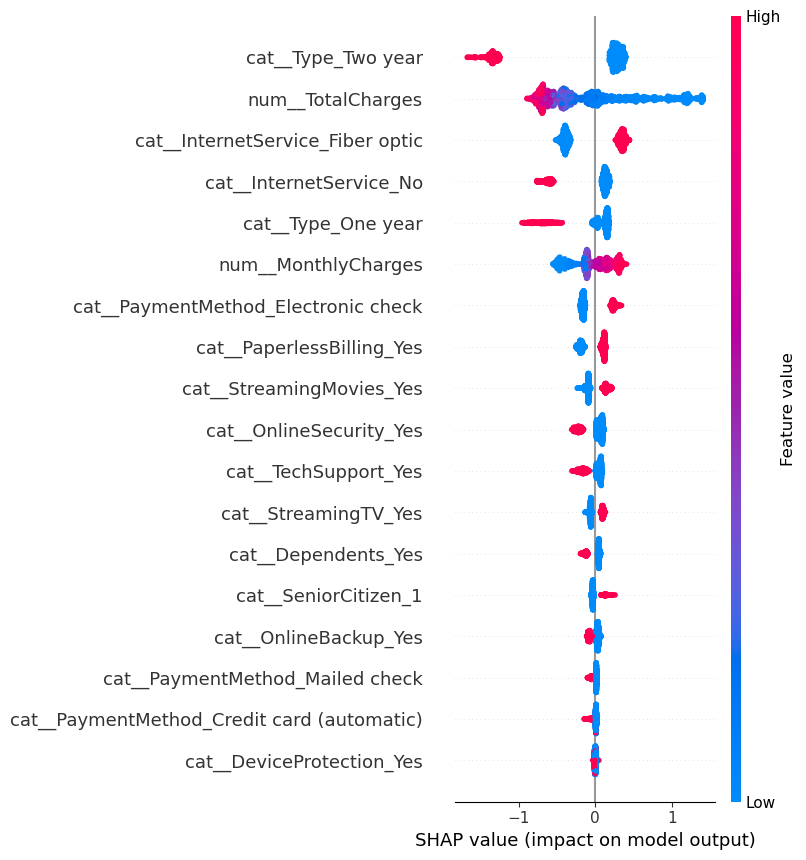

In [98]:
explainer = shap.Explainer(best_model['classifier'])
shap_values = explainer.shap_values(pipeline_catboost.named_steps['preprocessor'].transform(X_test))
feature_names = pipeline_catboost.named_steps['preprocessor'].get_feature_names_out()
shap.summary_plot(shap_values, pipeline_catboost.named_steps['preprocessor'].transform(X_test), feature_names=feature_names)

Можно заметить что период оплаты и сумма оплаты ( Type, TotalCharges, MontlyCharges) - основные в определении классов. Наибольшее значение для модели имеет признак Type ( Two year). Остальные признаки, кроме DeviseProtection (Yes) так же участвуют в определении классов.

Дополнительное исследование признака Type ( Two year).

In [103]:
df_two_year = df[df['Type'] == 'Two year']

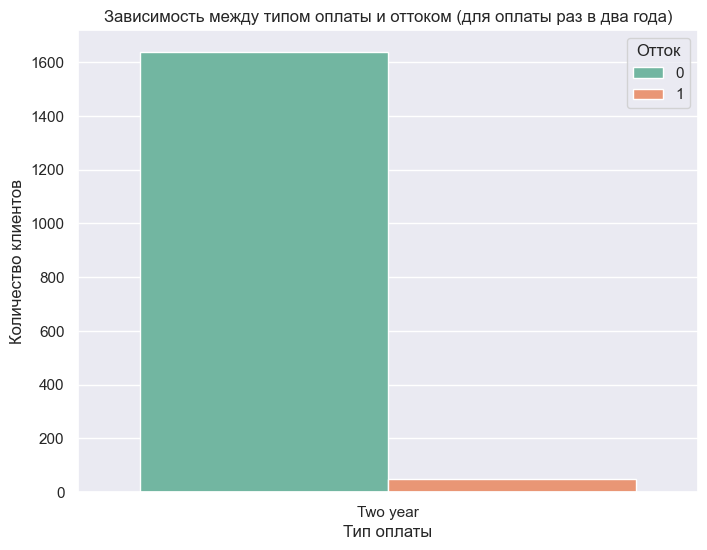

In [108]:
sns.set(style='darkgrid')
plt.figure(figsize=(8, 6))
sns.countplot(x='Type', hue='churn', data=df_two_year, palette='Set2')

plt.xlabel('Тип оплаты')
plt.ylabel('Количество клиентов')
plt.title('Зависимость между типом оплаты и оттоком (для оплаты раз в два года)')
plt.legend(title='Отток', loc='upper right')

plt.show()

Действительно очень важный признак. Отчетливо видно что клиенты с контрактом на 2 года - практически не уходят. Связанно это еще с и времеенной выборкой конечно, но все таки клиенты редко разрывают контракты. 

<a name='Вывод'></a>

### Вывод

Что бы определить кому в итоге выдавать промокоды - следует обратить внимание на клиентов с помесячной оплатой и высокими расходами. Так же стоит рассмотреть возможность стимуляции клиентов на оплату раз в два года, или хотя бы год -  в этой группе самый низкий отток. Явно есть проблемы с качеством интернета на  оптоволокне  и спосбом оплаты электронным чеком. Стоит обратить внимание на это и дополнительно проанализировать почему наблюдается высокий отток при исользовании этих услуг. Возможно имеет смысл предлагать хорошие условия для клиентов при подключении большого спектра услуг одним пакетом и на длительный срок. 

По проекту.С задачей справились, модель - рабочая. Можно улучшить качество и думаю довести точность до 90+ при двух/трех кратном увеличении объема данных. На таком сравнительно небольшом объеме + маленький срок наблюдения модель справляется приемлимо. 